# Customer Churn Prediction with XGBoost and SMOTE-ENN

- Customer churn prediction is a binary classification problem to be solved by supervised learning.
- Let's use major supervised learning algorithm and compare the results.
  - Logistic regression
  - KNN
  - SVM
  - Decision Tree
  - Random Forest
  - AdaBoost
  - XGBoost
- The data is imbalanced, so apply rebalancing methods and compare their results  with those of baseline models.
  - Baseline models: Imbalanced data
  - SMOTE
  - SMOTE-ENN
- Performance measure
  - Accuracy
  - Recall
  - F1 score
  - AUC score

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customers/BankChurners.csv


# 1. Load and Explore Dataset

In [2]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Load the dataset
df=pd.read_csv('../input/credit-card-customers/BankChurners.csv')

In [4]:
# According to the data details, "The PLEASE IGNORE THE LAST 2 COLUMNS (NAIVE BAYES CLAS…)" so we should delete the last 2 columns.
# First display the column names
df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [5]:
# Delete the last two columns
# "CLIENTNUM" is not needed for prediction. So, let's delete it.
df=df.drop(["CLIENTNUM",
            "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
            "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"],
           axis = 1)

In [6]:
# Display first five rows
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [7]:
# Display dataset shape
df.shape

(10127, 20)

In [8]:
# Display descriptive statistics
df.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [9]:
# Display data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

- There are no missing values in this dataset. 
- Some are categorical variables. So we need to encode them.
  - They are "Attrition_Flag","Gender","Education_Level","Marital_Status","Income_Category","Card_Category"

# 2. Data preprocessing

# 2.1. Convert categorical variables to numerical

In [10]:
# Show the unique values of categorical variables
print("Attrition_Flag :",df["Attrition_Flag"].unique())
print("Gender         :",df["Gender"].unique())
print("Education_Level:",df["Education_Level"].unique())
print("Marital_Status :",df["Marital_Status"].unique())
print("Income_Category:",df["Income_Category"].unique())
print("Card_Category  :",df["Card_Category"].unique())

Attrition_Flag : ['Existing Customer' 'Attrited Customer']
Gender         : ['M' 'F']
Education_Level: ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
Marital_Status : ['Married' 'Single' 'Unknown' 'Divorced']
Income_Category: ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
Card_Category  : ['Blue' 'Gold' 'Silver' 'Platinum']


In [11]:
# Convert variables with two categories into binary variables
df.loc[df["Attrition_Flag"] == "Existing Customer", "Attrition_Flag"] = 0
df.loc[df["Attrition_Flag"] == "Attrited Customer", "Attrition_Flag"] = 1
df["Attrition_Flag"] = df["Attrition_Flag"].astype(int)

df.loc[df["Gender"] == "F", "Gender"] = 0
df.loc[df["Gender"] == "M", "Gender"] = 1
df["Gender"] = df["Gender"].astype(int)

In [12]:
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,1,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,0,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,1,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,0,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,1,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [13]:
#One hot encoding for Categorical variables
df = pd.get_dummies(df)
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,1,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
1,0,49,0,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
2,0,51,1,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,0,40,0,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
4,0,40,1,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0


## 2.2. Train-Test split

In [14]:
# Split data into train and test Datasets

# Separate the dataset into features and target
X = df.drop(["Attrition_Flag"],axis=1)
y = df["Attrition_Flag"]

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y, random_state=101)

In [15]:
# Scale the data

# Standardize the columns the values of which are out of 0-1 range
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# Check the data balance

# Count the number of churn (=1)
y.value_counts()

0    8500
1    1627
Name: Attrition_Flag, dtype: int64

In [17]:
### Check the churn rate
churn_rate = (sum(df['Attrition_Flag'])/len(df['Attrition_Flag'].index))*100
churn_rate

16.065962279055988

The employee churn rate is 23.8. We can say that it is an imbalanced dataset.

## 3. Prediction with Imbalanced Data: Baseline models

## 3.1.Logistic Regression with Imbalanced Data

In [18]:
# Initiate the model
base_lm = LogisticRegression()
# Fit the model
base_lm_model = base_lm.fit(X_train, y_train.ravel())
# Make Predictions
base_lm_pred=base_lm_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_lm_accuracy = accuracy_score(y_test, base_lm_pred)
base_lm_precision = precision_score(y_test, base_lm_pred)
base_lm_recall = recall_score(y_test, base_lm_pred)
base_lm_f1 = 2 * (base_lm_precision * base_lm_recall) / (base_lm_precision + base_lm_recall)

# Calculate AUC score
base_lm_probs = base_lm.predict_proba(X_test)
base_lm_probs = base_lm_probs[:,1]
base_lm_auc = roc_auc_score(y_test, base_lm_probs)

# Display the metrics
print("Logistic Regression: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_lm_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_lm_precision))
print(" - Recall   : ",'{:.3f}'.format(base_lm_recall))
print(" - F1 score : ",'{:.3f}'.format(base_lm_f1))
print(" - AUC score: ",'{:.3f}'.format(base_lm_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_lm_pred))

Logistic Regression: Imbalanced Data
 - Accuracy :  0.904
 - Precision:  0.767
 - Recall   :  0.574
 - F1 score :  0.657
 - AUC score:  0.920
Confusion Matrix
[[2466   85]
 [ 208  280]]


## 3.2. KNN with Imbalanced Data

In [19]:
# Initiate the model
base_knn = KNeighborsClassifier()
# Fit the model
base_knn_model = base_knn.fit(X_train, y_train.ravel())
# Make Predictions
base_knn_pred=base_knn_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_knn_accuracy = accuracy_score(y_test, base_knn_pred)
base_knn_precision = precision_score(y_test, base_knn_pred)
base_knn_recall = recall_score(y_test, base_knn_pred)
base_knn_f1 = 2 * (base_knn_precision * base_knn_recall) / (base_knn_precision + base_knn_recall)

# Calculate AUC score
base_knn_probs = base_knn.predict_proba(X_test)
base_knn_probs = base_knn_probs[:,1]
base_knn_auc = roc_auc_score(y_test, base_knn_probs)

# Display the metrics
print("KNN Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_knn_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_knn_precision))
print(" - Recall   : ",'{:.3f}'.format(base_knn_recall))
print(" - F1 score : ",'{:.3f}'.format(base_knn_f1))
print(" - AUC score: ",'{:.3f}'.format(base_knn_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_knn_pred))

KNN Classifier: Imbalanced Data
 - Accuracy :  0.871
 - Precision:  0.740
 - Recall   :  0.303
 - F1 score :  0.430
 - AUC score:  0.794
Confusion Matrix
[[2499   52]
 [ 340  148]]


### 3.3. SVM with Imbalanced Data

In [20]:
# Initiate the model
base_svc = SVC(kernel='rbf',probability=True)
# Fit the model
base_svc_model = base_svc.fit(X_train, y_train.ravel())
# Make Predictions
base_svc_pred = base_svc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_svc_accuracy = accuracy_score(y_test, base_svc_pred)
base_svc_precision = precision_score(y_test, base_svc_pred)
base_svc_recall = recall_score(y_test, base_svc_pred)
base_svc_f1 = 2 * (base_svc_precision * base_svc_recall) / (base_svc_precision + base_svc_recall)

# Calculate AUC score
base_svc_probs = base_svc.predict_proba(X_test)
base_svc_probs = base_svc_probs[:,1]
base_svc_auc = roc_auc_score(y_test, base_svc_probs)

# Display the metrics
print("SVM Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_svc_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_svc_precision))
print(" - Recall   : ",'{:.3f}'.format(base_svc_recall))
print(" - F1 score : ",'{:.3f}'.format(base_svc_f1))
print(" - AUC score: ",'{:.3f}'.format(base_svc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_svc_pred))

SVM Classifier: Imbalanced Data
 - Accuracy :  0.919
 - Precision:  0.869
 - Recall   :  0.586
 - F1 score :  0.700
 - AUC score:  0.943
Confusion Matrix
[[2508   43]
 [ 202  286]]


### 3.4. Decision Tree with Imbalanced Data

In [21]:
# Initiate the model
base_tree = DecisionTreeClassifier()
# Fit the model
base_tree_model = base_tree.fit(X_train, y_train.ravel())
# Make Predictions
base_tree_pred=base_tree_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_tree_accuracy = accuracy_score(y_test, base_tree_pred)
base_tree_precision = precision_score(y_test, base_tree_pred)
base_tree_recall = recall_score(y_test, base_tree_pred)
base_tree_f1 = 2 * (base_tree_precision * base_tree_recall) / (base_tree_precision + base_tree_recall)

# Calculate AUC score
base_tree_probs = base_tree.predict_proba(X_test)
base_tree_probs = base_tree_probs[:,1]
base_tree_auc = roc_auc_score(y_test, base_tree_probs)

# Display the metrics
print("Decision Tree Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_tree_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_tree_precision))
print(" - Recall   : ",'{:.3f}'.format(base_tree_recall))
print(" - F1 score : ",'{:.3f}'.format(base_tree_f1))
print(" - AUC score: ",'{:.3f}'.format(base_tree_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_tree_pred))

Decision Tree Classifier: Imbalanced Data
 - Accuracy :  0.938
 - Precision:  0.816
 - Recall   :  0.791
 - F1 score :  0.803
 - AUC score:  0.878
Confusion Matrix
[[2464   87]
 [ 102  386]]


### 3.5. Random Forest with Imbalanced Data

In [22]:
# Initiate the model
base_rfc = RandomForestClassifier()
# Fit the model
base_rfc_model = base_rfc.fit(X_train, y_train.ravel())
# Make Predictions
base_rfc_pred=base_rfc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_rfc_accuracy = accuracy_score(y_test, base_rfc_pred)
base_rfc_precision = precision_score(y_test, base_rfc_pred)
base_rfc_recall = recall_score(y_test, base_rfc_pred)
base_rfc_f1 = 2 * (base_rfc_precision * base_rfc_recall) / (base_rfc_precision + base_rfc_recall)

# Calculate AUC score
base_rfc_probs = base_rfc.predict_proba(X_test)
base_rfc_probs = base_rfc_probs[:,1]
base_rfc_auc = roc_auc_score(y_test, base_rfc_probs)

# Display the metrics
print("Random Forest Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_rfc_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_rfc_precision))
print(" - Recall   : ",'{:.3f}'.format(base_rfc_recall))
print(" - F1 score : ",'{:.3f}'.format(base_rfc_f1))
print(" - AUC score: ",'{:.3f}'.format(base_rfc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_rfc_pred))

Random Forest Classifier: Imbalanced Data
 - Accuracy :  0.956
 - Precision:  0.927
 - Recall   :  0.785
 - F1 score :  0.850
 - AUC score:  0.985
Confusion Matrix
[[2521   30]
 [ 105  383]]


### 3.6. AdaBoost with Imbalanced Data

In [23]:
# Initiate the model
base_adb = AdaBoostClassifier()
# Fit the model
base_adb_model = base_adb.fit(X_train, y_train.ravel())
# Make Predictions
base_adb_pred=base_adb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_adb_accuracy = accuracy_score(y_test, base_adb_pred)
base_adb_precision = precision_score(y_test, base_adb_pred)
base_adb_recall = recall_score(y_test, base_adb_pred)
base_adb_f1 = 2 * (base_adb_precision * base_adb_recall) / (base_adb_precision + base_adb_recall)

# Calculate AUC score
base_adb_probs = base_adb.predict_proba(X_test)
base_adb_probs = base_adb_probs[:,1]
base_adb_auc = roc_auc_score(y_test, base_adb_probs)

# Display the metrics
print("AdaBoost Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_adb_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_adb_precision))
print(" - Recall   : ",'{:.3f}'.format(base_adb_recall))
print(" - F1 score : ",'{:.3f}'.format(base_adb_f1))
print(" - AUC score: ",'{:.3f}'.format(base_adb_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_adb_pred))

AdaBoost Classifier: Imbalanced Data
 - Accuracy :  0.957
 - Precision:  0.905
 - Recall   :  0.816
 - F1 score :  0.858
 - AUC score:  0.986
Confusion Matrix
[[2509   42]
 [  90  398]]


### 3.7. XGBoost with Imbalance Data

In [24]:
# Initiate the model
base_xgb = XGBClassifier()
# Fit the model
base_xgb_model = base_xgb.fit(X_train, y_train.ravel())
# Make Predictions
base_xgb_pred = base_xgb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
base_xgb_accuracy = accuracy_score(y_test, base_xgb_pred)
base_xgb_precision = precision_score(y_test, base_xgb_pred)
base_xgb_recall = recall_score(y_test, base_xgb_pred)
base_xgb_f1 = 2 * (base_xgb_precision * base_xgb_recall) / (base_xgb_precision + base_xgb_recall)

# Calculate AUC score
base_xgb_probs = base_xgb.predict_proba(X_test)
base_xgb_probs = base_xgb_probs[:,1]
base_xgb_auc = roc_auc_score(y_test, base_xgb_probs)

# Display the metrics
print("XGBoost Classifier: Imbalanced Data")
print(" - Accuracy : ",'{:.3f}'.format(base_xgb_accuracy))
print(" - Precision: ",'{:.3f}'.format(base_xgb_precision))
print(" - Recall   : ",'{:.3f}'.format(base_xgb_recall))
print(" - F1 score : ",'{:.3f}'.format(base_xgb_f1))
print(" - AUC score: ",'{:.3f}'.format(base_xgb_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,base_xgb_pred))

[16:51:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Classifier: Imbalanced Data
 - Accuracy :  0.970
 - Precision:  0.946
 - Recall   :  0.861
 - F1 score :  0.901
 - AUC score:  0.994
Confusion Matrix
[[2527   24]
 [  68  420]]


## 4. Prediction with SMOTE

## Perform SMOTE

In [25]:
# Since this is an imbalanced data, apply SMOTE to the training set
from imblearn.over_sampling import SMOTE
smote=SMOTE()
smote_X_train, smote_y_train = smote.fit_sample(X_train,y_train)

# Check if SMOTE were properly applied
smote_y_train.value_counts()

0    5949
1    5949
Name: Attrition_Flag, dtype: int64

SMOTE successfully made the dataset balanced

## 4.1. Logisgic Regression with SMOTE

In [26]:
# Initiate the model
smote_lm = LogisticRegression()

# Fit the model
smote_lm_model = smote_lm.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_lm_pred=smote_lm_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_lm_accuracy = accuracy_score(y_test, smote_lm_pred)
smote_lm_precision = precision_score(y_test, smote_lm_pred)
smote_lm_recall = recall_score(y_test, smote_lm_pred)
smote_lm_f1 = 2 * (smote_lm_precision * smote_lm_recall) / (smote_lm_precision + smote_lm_recall)

# Calculate AUC score
smote_lm_probs = smote_lm.predict_proba(X_test)
smote_lm_probs = smote_lm_probs[:,1]
smote_lm_auc = roc_auc_score(y_test, smote_lm_probs)

# Display the metrics
print("Logistic Regression: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_lm_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_lm_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_lm_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_lm_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_lm_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_lm_pred))

Logistic Regression: SMOTE
 - Accuracy :  0.853
 - Precision:  0.528
 - Recall   :  0.803
 - F1 score :  0.637
 - AUC score:  0.920
Confusion Matrix
[[2200  351]
 [  96  392]]


## 4.2. KNN with SMOTE

In [27]:
# Initiate the model
smote_knn = KNeighborsClassifier()

# Fit the model
smote_knn_model = smote_knn.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_knn_pred=smote_knn_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_knn_accuracy = accuracy_score(y_test, smote_knn_pred)
smote_knn_precision = precision_score(y_test, smote_knn_pred)
smote_knn_recall = recall_score(y_test, smote_knn_pred)
smote_knn_f1 = 2 * (smote_knn_precision * smote_knn_recall) / (smote_knn_precision + smote_knn_recall)

# Calculate AUC score
smote_knn_probs = smote_knn.predict_proba(X_test)
smote_knn_probs = smote_knn_probs[:,1]
smote_knn_auc = roc_auc_score(y_test, smote_knn_probs)

# Display the metrics
print("KNN Classifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_knn_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_knn_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_knn_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_knn_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_knn_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_knn_pred))

KNN Classifier: SMOTE
 - Accuracy :  0.765
 - Precision:  0.376
 - Recall   :  0.703
 - F1 score :  0.490
 - AUC score:  0.808
Confusion Matrix
[[1982  569]
 [ 145  343]]


## 4.3. SVM with SMOTE

In [28]:
# Initiate the model
smote_svc = SVC(kernel='rbf',probability=True)

# Fit the model
smote_svc_model = smote_svc.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_svc_pred=smote_svc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_svc_accuracy = accuracy_score(y_test, smote_svc_pred)
smote_svc_precision = precision_score(y_test, smote_svc_pred)
smote_svc_recall = recall_score(y_test, smote_svc_pred)
smote_svc_f1 = 2 * (smote_svc_precision * smote_svc_recall) / (smote_svc_precision + smote_svc_recall)

# Calculate AUC score
smote_svc_probs = smote_svc.predict_proba(X_test)
smote_svc_probs = smote_svc_probs[:,1]
smote_svc_auc = roc_auc_score(y_test, smote_svc_probs)

# Display the metrics
print("SVM Classifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_svc_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_svc_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_svc_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_svc_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_svc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_svc_pred))

SVM Classifier: SMOTE
 - Accuracy :  0.904
 - Precision:  0.669
 - Recall   :  0.799
 - F1 score :  0.728
 - AUC score:  0.944
Confusion Matrix
[[2358  193]
 [  98  390]]


## 4.4. Decision Tree Classifier with SMOTE

In [29]:
# Initiate the model
smote_tree = DecisionTreeClassifier()

# Fit the model
smote_tree_model = smote_tree.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_tree_pred=smote_tree_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_tree_accuracy = accuracy_score(y_test, smote_tree_pred)
smote_tree_precision = precision_score(y_test, smote_tree_pred)
smote_tree_recall = recall_score(y_test, smote_tree_pred)
smote_tree_f1 = 2 * (smote_tree_precision * smote_tree_recall) / (smote_tree_precision + smote_tree_recall)

# Calculate AUC score
smote_tree_probs = smote_tree.predict_proba(X_test)
smote_tree_probs = smote_tree_probs[:,1]
smote_tree_auc = roc_auc_score(y_test, smote_tree_probs)

# Display the metrics
print("Decision Tree Classifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_tree_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_tree_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_tree_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_tree_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_tree_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_tree_pred))

Decision Tree Classifier: SMOTE
 - Accuracy :  0.918
 - Precision:  0.721
 - Recall   :  0.803
 - F1 score :  0.760
 - AUC score:  0.872
Confusion Matrix
[[2399  152]
 [  96  392]]


## 4.5. Random Forest Classifier with SMOTE

In [30]:
# Initiate the model
smote_rfc = RandomForestClassifier()

# Fit the model
smote_rfc_model = smote_rfc.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_rfc_pred = smote_rfc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_rfc_accuracy = accuracy_score(y_test, smote_rfc_pred)
smote_rfc_precision = precision_score(y_test, smote_rfc_pred)
smote_rfc_recall = recall_score(y_test, smote_rfc_pred)
smote_rfc_f1 = 2 * (smote_rfc_precision * smote_rfc_recall) / (smote_rfc_precision + smote_rfc_recall)

# Calculate AUC score
smote_rfc_probs = smote_rfc.predict_proba(X_test)
smote_rfc_probs = smote_rfc_probs[:,1]
smote_rfc_auc = roc_auc_score(y_test, smote_rfc_probs)

# Display the metrics
print("Random Forest Classifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_rfc_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_rfc_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_rfc_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_rfc_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_rfc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_rfc_pred))

Random Forest Classifier: SMOTE
 - Accuracy :  0.957
 - Precision:  0.884
 - Recall   :  0.840
 - F1 score :  0.861
 - AUC score:  0.984
Confusion Matrix
[[2497   54]
 [  78  410]]


## 4.6. AdaBoost Classifier with SMOTE

In [31]:
# Initiate the model
smote_adb = AdaBoostClassifier()

# Fit the model
smote_adb_model = smote_adb.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_adb_pred = smote_adb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_adb_accuracy = accuracy_score(y_test, smote_adb_pred)
smote_adb_precision = precision_score(y_test, smote_adb_pred)
smote_adb_recall = recall_score(y_test, smote_adb_pred)
smote_adb_f1 = 2 * (smote_adb_precision * smote_adb_recall) / (smote_adb_precision + smote_adb_recall)

# Calculate AUC score
smote_adb_probs = smote_adb.predict_proba(X_test)
smote_adb_probs = smote_adb_probs[:,1]
smote_adb_auc = roc_auc_score(y_test, smote_adb_probs)

# Display the metrics
print("AdaBoost Classifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_adb_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_adb_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_adb_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_adb_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_adb_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_adb_pred))

AdaBoost Classifier: SMOTE
 - Accuracy :  0.938
 - Precision:  0.774
 - Recall   :  0.871
 - F1 score :  0.820
 - AUC score:  0.976
Confusion Matrix
[[2427  124]
 [  63  425]]


## 4.7. XGBoost Classifier with SMOTE

In [32]:
# Initiate the model
smote_xgb = XGBClassifier()

# Fit the model
smote_xgb_model = smote_xgb.fit(smote_X_train, smote_y_train.ravel())

# Make Predictions
smote_xgb_pred = smote_xgb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smote_xgb_accuracy = accuracy_score(y_test, smote_xgb_pred)
smote_xgb_precision = precision_score(y_test, smote_xgb_pred)
smote_xgb_recall = recall_score(y_test, smote_xgb_pred)
smote_xgb_f1 = 2 * (smote_xgb_precision * smote_xgb_recall) / (smote_xgb_precision + smote_xgb_recall)

# Calculate AUC score
smote_xgb_probs = smote_xgb.predict_proba(X_test)
smote_xgb_probs = smote_xgb_probs[:,1]
smote_xgb_auc = roc_auc_score(y_test, smote_xgb_probs)

# Display the metrics
print("XGBClassifier: SMOTE")
print(" - Accuracy : ",'{:.3f}'.format(smote_xgb_accuracy))
print(" - Precision: ",'{:.3f}'.format(smote_xgb_precision))
print(" - Recall   : ",'{:.3f}'.format(smote_xgb_recall))
print(" - F1 score : ",'{:.3f}'.format(smote_xgb_f1))
print(" - AUC score: ",'{:.3f}'.format(smote_xgb_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smote_xgb_pred))

[16:51:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier: SMOTE
 - Accuracy :  0.970
 - Precision:  0.921
 - Recall   :  0.889
 - F1 score :  0.905
 - AUC score:  0.992
Confusion Matrix
[[2514   37]
 [  54  434]]


# 5. Prediction with SMOTE-ENN

## Perform SMOTE-ENN

In [33]:
# Combined SMOTE and Edited Nearest Neighbors sampling for imbalanced classification
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

# define sampling
smoteenn_X_train, smoteenn_y_train=SMOTEENN(
    enn=EditedNearestNeighbours(sampling_strategy='majority')).fit_sample(X_train,y_train)

# Check if SMOTE-ENN were properly applied
smoteenn_y_train.value_counts()

1    5949
0    4050
Name: Attrition_Flag, dtype: int64

## 5.1. Logistic Regression with SMOTE-ENN

In [34]:
# Initiate the model
smoteenn_lm = LogisticRegression()

# Fit the model
smoteenn_lm_model = smoteenn_lm.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_lm_pred=smoteenn_lm_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_lm_accuracy = accuracy_score(y_test, smoteenn_lm_pred)
smoteenn_lm_precision = precision_score(y_test, smoteenn_lm_pred)
smoteenn_lm_recall = recall_score(y_test, smoteenn_lm_pred)
smoteenn_lm_f1 = 2 * (smoteenn_lm_precision * smoteenn_lm_recall) / (smoteenn_lm_precision + smoteenn_lm_recall)

# Calculate AUC score
smoteenn_lm_probs = smoteenn_lm.predict_proba(X_test)
smoteenn_lm_probs = smoteenn_lm_probs[:,1]
smoteenn_lm_auc = roc_auc_score(y_test, smoteenn_lm_probs)

# Display the metrics
print("Logistic Regression: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_lm_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_lm_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_lm_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_lm_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_lm_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_lm_pred))

Logistic Regression: SMOTE-ENN
 - Accuracy :  0.806
 - Precision:  0.445
 - Recall   :  0.855
 - F1 score :  0.585
 - AUC score:  0.917
Confusion Matrix
[[2031  520]
 [  71  417]]


## 5.2. KNN with SMOTE-ENN

In [35]:
# Initiate the model
smoteenn_knn = KNeighborsClassifier()

# Fit the model
smoteenn_knn_model = smoteenn_knn.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_knn_pred=smoteenn_knn_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_knn_accuracy = accuracy_score(y_test, smoteenn_knn_pred)
smoteenn_knn_precision = precision_score(y_test, smoteenn_knn_pred)
smoteenn_knn_recall = recall_score(y_test, smoteenn_knn_pred)
smoteenn_knn_f1 = 2 * (smoteenn_knn_precision * smoteenn_knn_recall) / (smoteenn_knn_precision + smoteenn_knn_recall)

# Calculate AUC score
smoteenn_knn_probs = smoteenn_knn.predict_proba(X_test)
smoteenn_knn_probs = smoteenn_knn_probs[:,1]
smoteenn_knn_auc = roc_auc_score(y_test, smoteenn_knn_probs)

# Display the metrics
print("KNN Classifier: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_knn_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_knn_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_knn_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_knn_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_knn_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_knn_pred))

KNN Classifier: SMOTE-ENN
 - Accuracy :  0.684
 - Precision:  0.313
 - Recall   :  0.807
 - F1 score :  0.451
 - AUC score:  0.790
Confusion Matrix
[[1685  866]
 [  94  394]]


## 5.3. SVM Classifier with SMOTE-ENN

In [36]:
# Initiate the model
smoteenn_svc = SVC(kernel='rbf',probability=True)

# Fit the model
smoteenn_svc_model = smoteenn_svc.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_svc_pred=smoteenn_svc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_svc_accuracy = accuracy_score(y_test, smoteenn_svc_pred)
smoteenn_svc_precision = precision_score(y_test, smoteenn_svc_pred)
smoteenn_svc_recall = recall_score(y_test, smoteenn_svc_pred)
smoteenn_svc_f1 = 2 * (smoteenn_svc_precision * smoteenn_svc_recall) / (smoteenn_svc_precision + smoteenn_svc_recall)

# Calculate AUC score
smoteenn_svc_probs = smoteenn_svc.predict_proba(X_test)
smoteenn_svc_probs = smoteenn_svc_probs[:,1]
smoteenn_svc_auc = roc_auc_score(y_test, smoteenn_svc_probs)

# Display the metrics
print("SVM Classifier: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_svc_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_svc_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_svc_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_svc_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_svc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_svc_pred))

SVM Classifier: SMOTE-ENN
 - Accuracy :  0.862
 - Precision:  0.545
 - Recall   :  0.863
 - F1 score :  0.668
 - AUC score:  0.936
Confusion Matrix
[[2199  352]
 [  67  421]]


## 5.4. Decision Tree Classifier with SMOTE-ENN

In [37]:
# Initiate the model
smoteenn_tree = DecisionTreeClassifier()

# Fit the model
smoteenn_tree_model = smoteenn_tree.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_tree_pred=smoteenn_tree_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_tree_accuracy = accuracy_score(y_test, smoteenn_tree_pred)
smoteenn_tree_precision = precision_score(y_test, smoteenn_tree_pred)
smoteenn_tree_recall = recall_score(y_test, smoteenn_tree_pred)
smoteenn_tree_f1 = 2 * (smoteenn_tree_precision * smoteenn_tree_recall) / (smoteenn_tree_precision + smoteenn_tree_recall)

# Calculate AUC score
smoteenn_tree_probs = smoteenn_tree.predict_proba(X_test)
smoteenn_tree_probs = smoteenn_tree_probs[:,1]
smoteenn_tree_auc = roc_auc_score(y_test, smoteenn_tree_probs)

# Display the metrics
print("Decision Tree Classifier: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_tree_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_tree_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_tree_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_tree_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_tree_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_tree_pred))

Decision Tree Classifier: SMOTE-ENN
 - Accuracy :  0.895
 - Precision:  0.632
 - Recall   :  0.828
 - F1 score :  0.717
 - AUC score:  0.868
Confusion Matrix
[[2316  235]
 [  84  404]]


## 5.5. Random Forest Classifier with SMOTE-ENN

In [38]:
# Initiate the model
smoteenn_rfc = RandomForestClassifier()

# Fit the model
smoteenn_rfc_model = smoteenn_rfc.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_rfc_pred = smoteenn_rfc_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_rfc_accuracy = accuracy_score(y_test, smoteenn_rfc_pred)
smoteenn_rfc_precision = precision_score(y_test, smoteenn_rfc_pred)
smoteenn_rfc_recall = recall_score(y_test, smoteenn_rfc_pred)
smoteenn_rfc_f1 = 2 * (smoteenn_rfc_precision * smoteenn_rfc_recall) / (smoteenn_rfc_precision + smoteenn_rfc_recall)

# Calculate AUC score
smoteenn_rfc_probs = smoteenn_rfc.predict_proba(X_test)
smoteenn_rfc_probs = smoteenn_rfc_probs[:,1]
smoteenn_rfc_auc = roc_auc_score(y_test, smoteenn_rfc_probs)

# Display the metrics
print("Random Forest Classifier: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_rfc_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_rfc_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_rfc_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_rfc_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_rfc_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_rfc_pred))

Random Forest Classifier: SMOTE-ENN
 - Accuracy :  0.929
 - Precision:  0.729
 - Recall   :  0.887
 - F1 score :  0.800
 - AUC score:  0.975
Confusion Matrix
[[2390  161]
 [  55  433]]


## 5.6. AdaBoost with SMOTE-ENN

In [39]:
# Initiate the model
smoteenn_adb = AdaBoostClassifier()

# Fit the model
smoteenn_adb_model = smoteenn_adb.fit(smoteenn_X_train, smoteenn_y_train.ravel())

# Make Predictions
smoteenn_adb_pred = smoteenn_adb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_adb_accuracy = accuracy_score(y_test, smoteenn_adb_pred)
smoteenn_adb_precision = precision_score(y_test, smoteenn_adb_pred)
smoteenn_adb_recall = recall_score(y_test, smoteenn_adb_pred)
smoteenn_adb_f1 = 2 * (smoteenn_adb_precision * smoteenn_adb_recall) / (smoteenn_adb_precision + smoteenn_adb_recall)

# Calculate AUC score
smoteenn_adb_probs = smoteenn_adb.predict_proba(X_test)
smoteenn_adb_probs = smoteenn_adb_probs[:,1]
smoteenn_adb_auc = roc_auc_score(y_test, smoteenn_adb_probs)

# Display the metrics
print("AdaBoost Classifier: SMOTE-ENN")
print(" - Accuracy : ",'{:.3f}'.format(smoteenn_adb_accuracy))
print(" - Precision: ",'{:.3f}'.format(smoteenn_adb_precision))
print(" - Recall   : ",'{:.3f}'.format(smoteenn_adb_recall))
print(" - F1 score : ",'{:.3f}'.format(smoteenn_adb_f1))
print(" - AUC score: ",'{:.3f}'.format(smoteenn_adb_auc))

# Display the confusion matrix
print("Confusion Matrix")
print(confusion_matrix(y_test,smoteenn_adb_pred))

AdaBoost Classifier: SMOTE-ENN
 - Accuracy :  0.924
 - Precision:  0.695
 - Recall   :  0.936
 - F1 score :  0.798
 - AUC score:  0.978
Confusion Matrix
[[2350  201]
 [  31  457]]


## 5.7. XGBoost Classifier with SMOTE-ENN

In [40]:
# Initiate the model
smoteenn_xgb = XGBClassifier()
# Fit the model
smoteenn_xgb_model =smoteenn_xgb.fit(smoteenn_X_train, smoteenn_y_train.ravel())
# Make Predictions
smoteenn_xgb_pred = smoteenn_xgb_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 score
smoteenn_xgb_accuracy = accuracy_score(y_test, smoteenn_xgb_pred)
smoteenn_xgb_precision = precision_score(y_test, smoteenn_xgb_pred)
smoteenn_xgb_recall = recall_score(y_test, smoteenn_xgb_pred)
smoteenn_xgb_f1 = 2 * (smoteenn_xgb_precision * smoteenn_xgb_recall) / (smoteenn_xgb_precision + smoteenn_xgb_recall)

# Calculate AUC score
smoteenn_xgb_probs = smoteenn_xgb.predict_proba(X_test)
smoteenn_xgb_probs = smoteenn_xgb_probs[:,1]
smoteenn_xgb_auc = roc_auc_score(y_test, smoteenn_xgb_probs)

# Display the metrics
print("XGB Classifier: SMOTEENN")
print(" - Accuracy: ", smoteenn_xgb_accuracy)
print(" - Precision: ", smoteenn_xgb_precision)
print(" - Recall: ", smoteenn_xgb_recall)
print(" - F1 score: ", smoteenn_xgb_f1)
print(" - AUC score: ", smoteenn_xgb_auc)

# Display the confusion matrix
print(confusion_matrix(y_test,smoteenn_xgb_pred))

[16:52:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Classifier: SMOTEENN
 - Accuracy:  0.9526159921026653
 - Precision:  0.8028169014084507
 - Recall:  0.9344262295081968
 - F1 score:  0.8636363636363635
 - AUC score:  0.9879041327412585
[[2439  112]
 [  32  456]]


# 6. Summary of Results

In [41]:
# Create Results Table: Accuracy 
pd.options.display.float_format = '{:.3f}'.format

acc_list = [
    [base_lm_accuracy, base_knn_accuracy, base_svc_accuracy, base_tree_accuracy, base_rfc_accuracy,
     base_adb_accuracy, base_xgb_accuracy],
    [smote_lm_accuracy, smote_knn_accuracy, smote_svc_accuracy, smote_tree_accuracy, smote_rfc_accuracy,
     smote_adb_accuracy, smote_xgb_accuracy],
    [smoteenn_lm_accuracy, smoteenn_knn_accuracy, smoteenn_svc_accuracy, smoteenn_tree_accuracy, 
     smoteenn_rfc_accuracy,smoteenn_adb_accuracy, smoteenn_xgb_accuracy]]

acc_df = pd.DataFrame(acc_list)
acc_df.index = ['BASE','SMOTE','SMOTE-ENN']
acc_df.columns = ['Logistic Regression','KNN','SVM','Decision Tree','Random Forest','AdaBoost','XGBoost']   

# Create Results Table: Recall
rec_list = [
    [base_lm_recall, base_knn_recall, base_svc_recall, base_tree_recall, base_rfc_recall,
     base_adb_recall, base_xgb_recall],
    [smote_lm_recall, smote_knn_recall, smote_svc_recall, smote_tree_recall, smote_rfc_recall,
     smote_adb_recall, smote_xgb_recall],
    [smoteenn_lm_recall, smoteenn_knn_recall, smoteenn_svc_recall, smoteenn_tree_recall, 
     smoteenn_rfc_recall,smoteenn_adb_recall, smoteenn_xgb_recall]]

rec_df = pd.DataFrame(rec_list)
rec_df.index = ['BASE','SMOTE','SMOTE-ENN']
rec_df.columns = ['Logistic Regression','KNN','SVM','Decision Tree','Random Forest','AdaBoost','XGBoost']

# Create Results Table: F1
f1_list = [
    [base_lm_f1, base_knn_f1, base_svc_f1, base_tree_f1, base_rfc_f1,base_adb_f1, base_xgb_f1],
    [smote_lm_f1, smote_knn_f1, smote_svc_f1, smote_tree_f1, smote_rfc_f1,smote_adb_f1, smote_xgb_f1],
    [smoteenn_lm_f1, smoteenn_knn_f1, smoteenn_svc_f1, smoteenn_tree_f1,smoteenn_rfc_f1,smoteenn_adb_f1, 
     smoteenn_xgb_f1]]

f1_df = pd.DataFrame(f1_list)
f1_df.index = ['BASE','SMOTE','SMOTE-ENN']
f1_df.columns = ['Logistic Regression','KNN','SVM','Decision Tree','Random Forest','AdaBoost','XGBoost']

# Create Results Table: AUC
auc_list = [
    [base_lm_auc, base_knn_auc, base_svc_auc, base_tree_auc, base_rfc_auc,base_adb_auc, base_xgb_auc],
    [smote_lm_auc, smote_knn_auc, smote_svc_auc, smote_tree_auc, smote_rfc_auc,smote_adb_auc, smote_xgb_auc],
    [smoteenn_lm_auc, smoteenn_knn_auc, smoteenn_svc_auc, smoteenn_tree_auc,smoteenn_rfc_auc,smoteenn_adb_auc, 
     smoteenn_xgb_auc]]

auc_df = pd.DataFrame(auc_list)
auc_df.index = ['BASE','SMOTE','SMOTE-ENN']
auc_df.columns = ['Logistic Regression','KNN','SVM','Decision Tree','Random Forest','AdaBoost','XGBoost']

In [42]:
print("Accuracy")
acc_df

Accuracy


,Logistic Regression,KNN,SVM,Decision Tree,Random Forest,AdaBoost,XGBoost
BASE,0.904,0.871,0.919,0.938,0.956,0.957,0.970
SMOTE,0.853,0.765,0.904,0.918,0.957,0.938,0.970
SMOTE-ENN,0.806,0.684,0.862,0.895,0.929,0.924,0.953


In [43]:
print("Recall")
rec_df

Recall


,Logistic Regression,KNN,SVM,Decision Tree,Random Forest,AdaBoost,XGBoost
BASE,0.574,0.303,0.586,0.791,0.785,0.816,0.861
SMOTE,0.803,0.703,0.799,0.803,0.840,0.871,0.889
SMOTE-ENN,0.855,0.807,0.863,0.828,0.887,0.936,0.934


In [44]:
print("F1 score")
f1_df

F1 score


,Logistic Regression,KNN,SVM,Decision Tree,Random Forest,AdaBoost,XGBoost
BASE,0.657,0.430,0.700,0.803,0.850,0.858,0.901
SMOTE,0.637,0.490,0.728,0.760,0.861,0.820,0.905
SMOTE-ENN,0.585,0.451,0.668,0.717,0.800,0.798,0.864


In [45]:
print("AUC")
auc_df

AUC


,Logistic Regression,KNN,SVM,Decision Tree,Random Forest,AdaBoost,XGBoost
BASE,0.920,0.794,0.943,0.878,0.985,0.986,0.994
SMOTE,0.920,0.808,0.944,0.872,0.984,0.976,0.992
SMOTE-ENN,0.917,0.790,0.936,0.868,0.975,0.978,0.988


- Baseline model achieved the highest performance.
- Among them, XGBoost achieve the highest performance. AUC score = 0.994

## ROC Curve

In [46]:
# Import the library for ROC curve.
from sklearn.metrics import roc_curve, roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]

prob_lm = base_lm_model.predict_proba(X_test)
prob_lm = prob_lm[:,1]

prob_knn = base_knn_model.predict_proba(X_test)
prob_knn = prob_knn[:,1]

prob_svc = base_svc_model.predict_proba(X_test)
prob_svc = prob_svc[:,1]

prob_tree = base_tree_model.predict_proba(X_test)
prob_tree = prob_tree[:,1]

prob_rfc = base_rfc_model.predict_proba(X_test)
prob_rfc = prob_rfc[:,1]

prob_adb = base_adb_model.predict_proba(X_test)
prob_adb = prob_adb[:,1]

prob_xgb = base_xgb_model.predict_proba(X_test)
prob_xgb = prob_xgb[:,1]

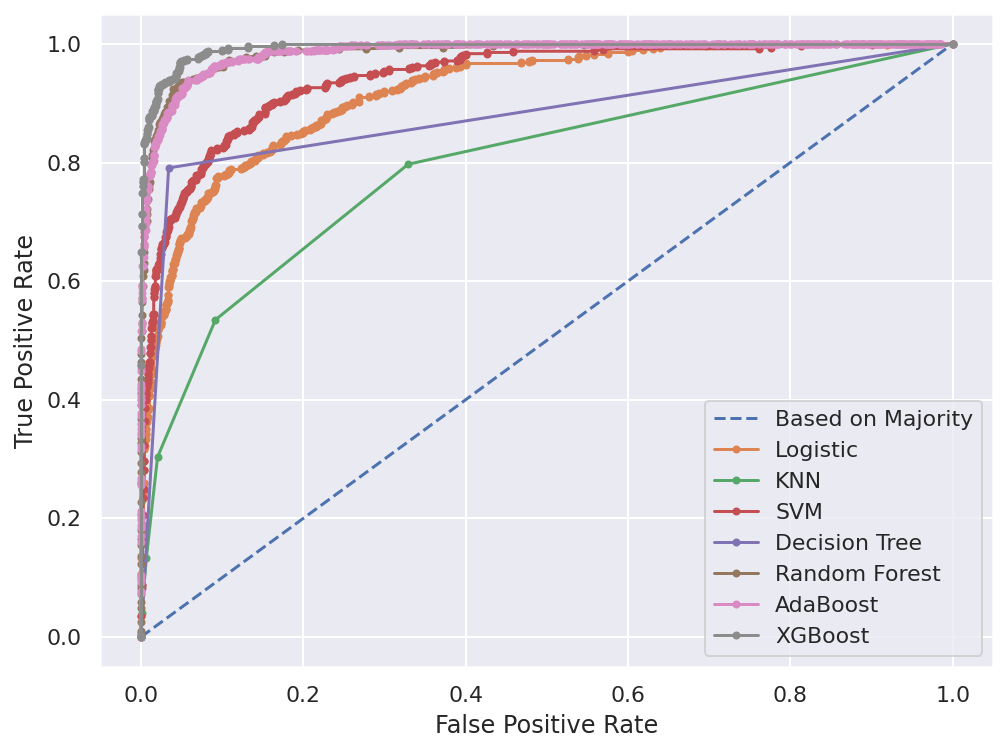

In [47]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lm_fpr, lm_tpr, _ = roc_curve(y_test, prob_lm)
knn_fpr, knn_tpr, _ = roc_curve(y_test, prob_knn)
svc_fpr, svc_tpr, _ = roc_curve(y_test, prob_svc)
tree_fpr, tree_tpr, _ = roc_curve(y_test, prob_tree)
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, prob_rfc)
adb_fpr, adb_tpr, _ = roc_curve(y_test, prob_adb)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Based on Majority')
plt.plot(lm_fpr, lm_tpr, marker='.', label='Logistic')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.plot(svc_fpr, svc_tpr, marker='.', label='SVM')
plt.plot(tree_fpr, tree_tpr, marker='.', label='Decision Tree')
plt.plot(rfc_fpr, rfc_tpr, marker='.', label='Random Forest')
plt.plot(adb_fpr, adb_tpr, marker='.', label='AdaBoost')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()